In [1]:
%run ../../modulos.ipynb

# Conexión a mongo

In [2]:
client=pymongo.MongoClient('mongodb://localhost:27017/')
db_Lichess=client['Lichess'] # database
usuarios_col=db_Lichess['usuarios'] # colección

# Obtener datos usuarios



In [10]:
def request_github(url,personal_access=personal_access_token):
    headers = {"Authorization": f"Bearer {personal_access}"}

    res=requests.get(url,headers=headers)
    return res.json()

In [3]:
def obtener_data_lichess(url):    
    headers = {"Authorization": f"Bearer {personal_access_token}"}    
    response = requests.get(url, headers=headers)    
    return response

def obtener_equipos_populares(url):    
    data = obtener_data_lichess(url)
    return data

In [4]:
grupos_unam_url = 'https://lichess.org/api/team/search?text=UNAM'
data = obtener_equipos_populares(grupos_unam_url).json()
club_prometeo = data['currentPageResults'][4]
id_club_prome = club_prometeo['id']

## Obtención de usuarios

In [7]:
data = requests.get('https://lichess.org/api/team/club-prometeo/users')
usuario_raw = data.text.split('\n')[:-1]
list_usuarios = list(map(json.loads, usuario_raw))

# Obtentencion de estadistica

In [11]:
def obtener_estadisticas(usuario, perf="blitz"):
    data = requests.get(f'https://lichess.org/api/user/{usuario}/perf/{perf}')
    return data.json()    

In [32]:
# Consulta para el ide del usuario

# Estadicar para partidas blitz
username = list_usuarios[0]['username']
perf = 'blitz'
estadisticas1 = obtener_estadisticas(username, perf)

In [33]:
oponentes_fuertes = estadisticas1['stat']['bestWins']['results'][:3]
ids_oponentes = [oponente['opId']['id'] for oponente in oponentes_fuertes]
ids_oponentes
obtener_estadisticas(ids_oponentes[2])

{'user': {'name': 'vladgert'},
 'perf': {'glicko': {'rating': 1427.09,
   'deviation': 80.32,
   'provisional': False},
  'nb': 4292,
  'progress': 5},
 'rank': None,
 'percentile': 40.9,
 'stat': {'_id': 'vladgert/2',
  'userId': {'id': 'vladgert', 'name': 'vladgert', 'title': None},
  'perfType': {'key': 'blitz', 'name': 'Blitz'},
  'highest': {'int': 1455,
   'at': '2021-11-09T18:44:16.284Z',
   'gameId': 'aNBQGvw2'},
  'lowest': {'int': 993,
   'at': '2019-11-14T21:06:43.174Z',
   'gameId': 'h8XAYi6A'},
  'bestWins': {'results': [{'opInt': 1546,
     'opId': {'id': 'achitescu', 'name': 'achitescu', 'title': None},
     'at': '2021-10-25T18:12:00.945Z',
     'gameId': '2MwbNJNM'},
    {'opInt': 1525,
     'opId': {'id': 'zen_knight', 'name': 'Zen_Knight', 'title': None},
     'at': '2021-05-20T13:49:58.008Z',
     'gameId': 'kd8bTsA9'},
    {'opInt': 1522,
     'opId': {'id': 'nassa2012', 'name': 'NaSSa2012', 'title': None},
     'at': '2020-12-12T13:15:16.569Z',
     'gameId': 'ewV

In [61]:
# Limpiar registros
# usuarios_col.drop()
# len(list(usuarios_col.find()))

0

# Neo4j

`docker run --name "Lichess_neo" -p 7474:7474 -p 7687:7687 neo4j `

In [3]:
from neo4j import GraphDatabase

data_base_connection = GraphDatabase.driver(uri="bolt://localhost:7687", auth=("neo4j", "1234"))
session = data_base_connection.session() 

In [60]:
# elimina toda la base de datos
# session.run('MATCH (n) DETACH DELETE n')
# q=session.run('MATCH (n) RETURN n')


In [62]:

# Guardarlo en mongo
for usuario in tqdm_notebook(list_usuarios):
  id_usuario=usuario['id']
  instruccion=f'''
MERGE (u:Usuario {{id:"{id_usuario}"}})
'''
  usuarios_col.insert_one({id_usuario:usuario})
  est_usuario=obtener_estadisticas(id_usuario)
  usuarios_col.update_one({ id_usuario : { '$exists' : 'true' } } ,{'$set': est_usuario})

  # oponentes
  oponentes_fuertes = est_usuario['stat']['bestWins']['results'][:]
  ids_oponentes = [oponente['opId']['id'] for oponente in oponentes_fuertes]


  j=0
  i=0
  while i<len(oponentes_fuertes) and j<3:
  # for id_op in ids_oponentes:
    
    id_op=ids_oponentes[i]
    
    i=i+1
    try:
      est_usuario1=obtener_estadisticas(id_op)
    except: 
      continue  
    j=j+1
    usuarios_col.insert_one({id_op:''})
    usuarios_col.update_one({ id_op : { '$exists' : 'true' } } ,{'$set': est_usuario1})
    instruccion+=f'''
    MERGE (u{i}:Usuario {{id:"{id_op}"}})
    MERGE (u)-[:gano_a]->(u{i})
  '''
    #op de oponente
    oponentes_fuertes1 = est_usuario1['stat']['bestWins']['results'][:3]
    ids_oponentes1 = [oponente['opId']['id'] for oponente in oponentes_fuertes1]
    for k,id_ops_de_ops in enumerate(ids_oponentes1):
      try:
        est_usuario2=obtener_estadisticas(id_ops_de_ops)
      except: 
        continue   
      usuarios_col.insert_one({id_ops_de_ops:''})
      usuarios_col.update_one({ id_ops_de_ops : { '$exists' : 'true' } } ,{'$set': est_usuario2})
      instruccion+=f'''
    MERGE (u{i}{k}:Usuario {{id:"{id_ops_de_ops}"}})
    MERGE (u{i})-[:gano_a]->(u{i}{k})
  '''

  session.run(instruccion)


C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/87 [00:00<?, ?it/s]

In [74]:
for usuario in tqm(list_usuarios):
  id_usuario=usuario['id']
  instruccion=f'''
MERGE (u:Usuario {{id:"{id_usuario}"}})
MERGE (e:Equipo {{nombre:"club_prometeo"}})
MERGE (u)-[:pertenece]->(e)
'''
  session.run(instruccion)

  0%|          | 0/87 [00:00<?, ?it/s]

In [75]:
instruccion='''match (u1:Usuario)
match (u2:Usuario)
match (u3:Usuario)
match (u1)-[:gano_a]->(u2)-[:gano_a]->(u3)
return u3,u1'''

a=session.run(instruccion)

# Consultas

- 5 becarios más prometedores

# Joins anidados de pandas

Hacer consulta de ¿Quienes han tenido en promedio los oponentes más difíciles? en pandas y en neo4j

Primero tener una tabla de ids y luego hacer petición a mongo

Lista de usuarios a usuarios a los que les han ganado

In [4]:
instruccion='''match (u1:Usuario)
match (u2:Usuario)
match (u1)-[:gano_a]->(u2)
return u1,u2'''

a=session.run(instruccion).data()


In [5]:
# construir el df
id1=[]
id2=[]
for ai in a:
  id1.append(ai['u1']['id'])
  id2.append(ai['u2']['id'])

df=pd.DataFrame({'id1':id1,'id2':id2})
df

,id1,id2
0,alanmezal,vladgert
1,alanmezal,fux58
2,alanmezal,medlar
3,medlar,sargan7
4,medlar,munjo123
...,...,...
691,tonatihus,promokc
692,tonatihus,sces1
693,quetahl,kaeptn_peng
694,quetahl,picay


In [14]:
# Obtén todas las victorias de las victorias


df1=pd.merge(left=df,right=df,left_on='id2',right_on='id1')

df1

,id1_x,id2_x,id1_y,id2_y
0,alanmezal,vladgert,vladgert,nassa2012
1,alanmezal,vladgert,vladgert,zen_knight
2,alanmezal,vladgert,vladgert,achitescu
3,alanmezal,fux58,fux58,nadir_sofiani
4,alanmezal,fux58,fux58,patrickmilen
...,...,...,...,...
517,h-cote,quetahl,quetahl,picay
518,h-cote,quetahl,quetahl,donyyrules
519,h-cote,angelxdxd,angelxdxd,eddsnow
520,h-cote,angelxdxd,angelxdxd,parwizqaderi


In [12]:

# con neo

instruccion='''match (u1:Usuario)
match (u2:Usuario)
match (u3:Usuario)
match (u1)-[:gano_a]->(u2)-[:gano_a]->(u3)
return u3,u1'''

a=session.run(instruccion).data()


0.08599638938903809

In [15]:
dicc_ind={}
for ai in a:
  id1=ai['u1']['id']
  id2=ai['u3']['id']
  if not dicc_ind.get(id1,False):
    dicc_ind[id1]=[id2]
  else:
    dicc_ind[id1].append(id2)

In [16]:
dicc_ind

{'alanmezal': ['rockisland',
  'munjo123',
  'sargan7',
  'patrickmilen',
  'nadir_sofiani',
  'achitescu',
  'zen_knight',
  'nassa2012'],
 'xngelguale': ['kanachess',
  'mattescooper89',
  'peterpanter',
  'titlewinner',
  'killer_programs',
  'zombyman',
  'kon_stan'],
 'quarknewton': ['schachschneider',
  'chess_earth',
  'vbzhadanov',
  'eremeev',
  'lokiespi',
  'mkhail-tal',
  'imatsuhermatmn',
  'ginzburg_yakov',
  'gulbari'],
 'xschoko': ['vladtok',
  'uakbay',
  'bossbuster',
  'johnnydawood',
  'sagitario64',
  'victorkorch',
  'gmols',
  'iamgm_betterthanyou',
  'novikovroman'],
 'elias_leal': ['jpaints',
  'jamalqassas',
  'mayur88',
  'krgaming',
  'alperenefebusra',
  'gonehurling',
  'ebukaaat20',
  'krisha1310',
  'manugross'],
 'alanrv': ['vencedor96',
  'uriel12321xd',
  'paraulata',
  'ssjgssj',
  'eduardonikov',
  'danbert',
  'legado-de-morphy'],
 'chevischevis09': ['jairsc01',
  'daenco2020',
  'xxpiagetgodxx',
  'astroxflo',
  'jbourne007',
  'bocah_csi',
  'dac

In [18]:
id_unam=[]
promedios=[]
greatest_rating=[]
current_rating=[]

for id1 in dicc_ind:
  prom=0
  i=0
  for id2 in dicc_ind[id1]:
    dicc_oponente=usuarios_col.find_one({id2:{'$exists':'true'}})
    try:
      i=i+1
      prom+=dicc_oponente['stat']['highest']['int']
    except:
      continue
    # Agarra promedio de victorias

  dicc_mongo=usuarios_col.find_one({id1:{'$exists':'true'}})
  if dicc_mongo[id1]=='':
    continue
  dict_perfs=dicc_mongo[id1].get('perfs',False)
  if dict_perfs:
    current_rating.append(dict_perfs['blitz']['rating'])
  else:
    continue
  if prom>0:
    promedios.append(round(prom/i,2))

  dict_high=dicc_mongo['stat'].get('highest',False)
  if dict_high:
    greatest_rating.append(dict_high['int'])
  else:
    greatest_rating.append(np.nan)
  id_unam.append(id1)

df_stats=pd.DataFrame({'id':id_unam,'mean_op': promedios,'greatest_rating':greatest_rating,'current_rating':current_rating})

In [19]:
df_stats

,id,mean_op,greatest_rating,current_rating
0,alanmezal,1783.38,1294.0,1280
1,xngelguale,2506.29,1656.0,1590
2,quarknewton,2462.33,1292.0,1195
3,xschoko,2106.33,1712.0,1647
4,elias_leal,1425.11,NaN,1185
...,...,...,...,...
59,brandonjoel1410,2146.22,1483.0,1465
60,doctorjzzz,2154.83,1712.0,1698
61,ianpineda01,1566.33,1145.0,1043
62,rulober10,2623.00,2013.0,1941


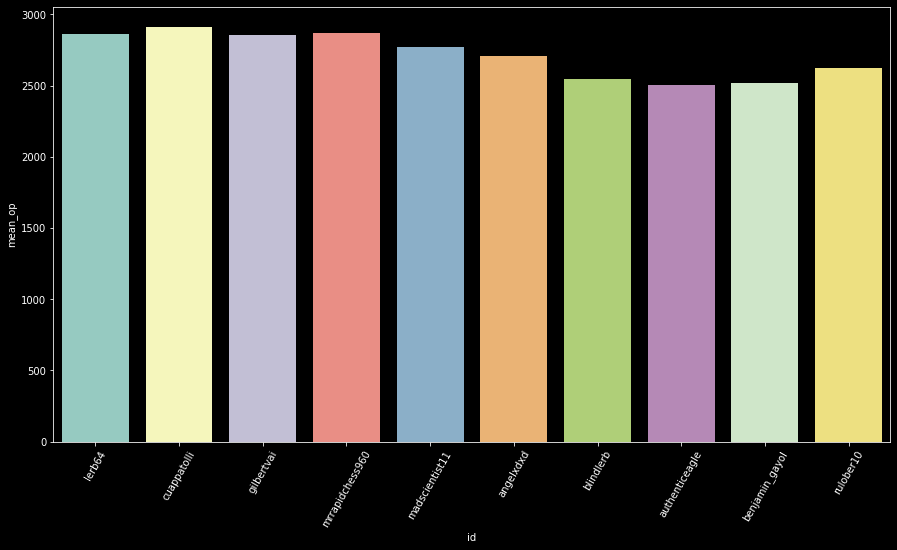

In [21]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.barplot(data=df_stats.sort_values('current_rating',ascending=False)[:10],x='id',y='mean_op')
plt.xticks(rotation=60)
plt.show()

In [22]:
top_jugadores=set()

[top_jugadores.add(pi) for pi in df_stats.sort_values('current_rating',ascending=False)[:10].id.values]
[top_jugadores.add(pi) for pi in df_stats.sort_values('greatest_rating',ascending=False)[:10].id.values]
[top_jugadores.add(pi) for pi in df_stats.sort_values('mean_op',ascending=False)[:10].id.values]

[None, None, None, None, None, None, None, None, None, None]

In [23]:
df_top=df_stats[df_stats.id.isin(top_jugadores)]
df_top['color']=sns.color_palette('Paired',n_colors=len(df_top))
df_top

c:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,mean_op,greatest_rating,current_rating,color
9,tennbeis,2759.80,1946.0,1839,"(0.6509803921568628, 0.807843137254902, 0.8901..."
10,agustin_pichicuaz,2685.00,2051.0,1940,"(0.12156862745098039, 0.47058823529411764, 0.7..."
12,cuappatolli,2908.38,2421.0,2347,"(0.6980392156862745, 0.8745098039215686, 0.541..."
14,blindlerb,2548.56,2111.0,2084,"(0.2, 0.6274509803921569, 0.17254901960784313)"
19,gilbertvai,2858.22,2333.0,2222,"(0.984313725490196, 0.6039215686274509, 0.6)"
21,madscientist11,2771.00,2265.0,2201,"(0.8901960784313725, 0.10196078431372549, 0.10..."
22,lerb64,2863.88,2516.0,2482,"(0.9921568627450981, 0.7490196078431373, 0.435..."
23,mrrapidchess960,2865.67,2303.0,2221,"(1.0, 0.4980392156862745, 0.0)"
33,georave,2640.14,1816.0,1757,"(0.792156862745098, 0.6980392156862745, 0.8392..."
36,authenticeagle,2505.50,2151.0,2067,"(0.41568627450980394, 0.23921568627450981, 0.6..."


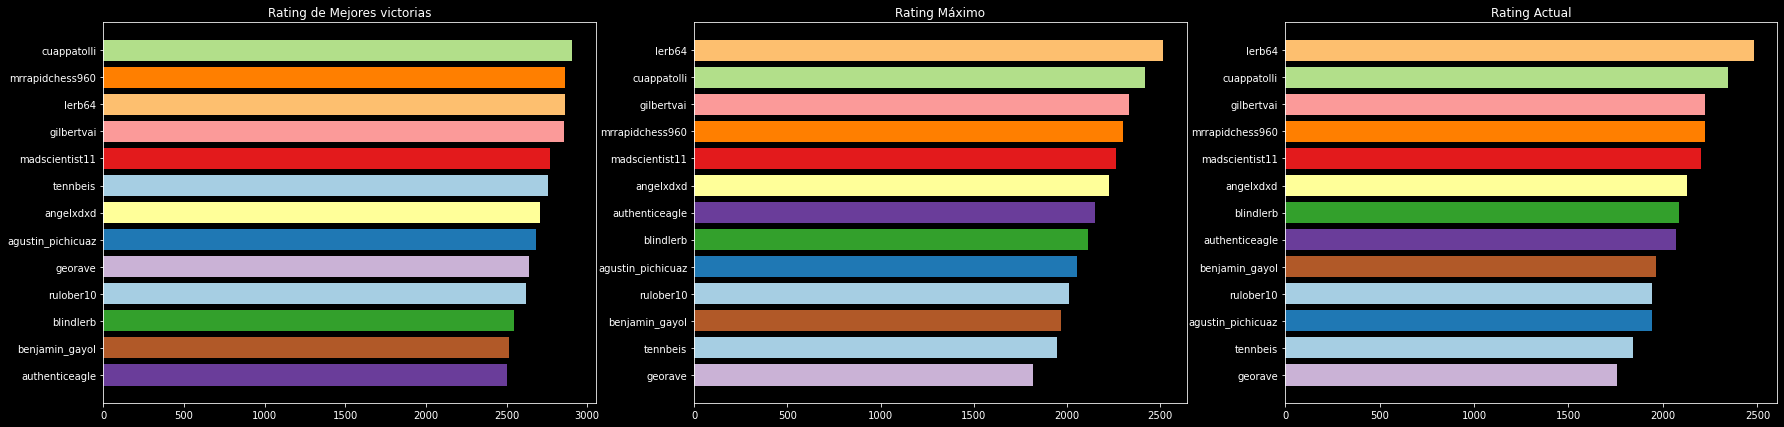

In [28]:


fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(30,7))
ax[0].barh(df_top.sort_values('mean_op')[:].id,df_top.sort_values('mean_op')[:].mean_op,color=df_top.sort_values('mean_op')[:]['color'])
ax[0].set_title('Rating de Mejores victorias')
ax[1].barh(df_top.sort_values('greatest_rating')[:].id,df_top.sort_values('greatest_rating')[:].greatest_rating,color=df_top.sort_values('greatest_rating')[:]['color'])
ax[1].set_title('Rating Máximo')
ax[2].barh(df_top.sort_values('current_rating')[:].id,df_top.sort_values('current_rating')[:].current_rating,color=df_top.sort_values('current_rating')[:]['color'])
ax[2].set_title('Rating Actual')

# ax.set_yticklabels(df_top.id,rotation=70)
plt.show()

In [122]:
# Gráfico que muestre el +- del número de lugares de cada quién. 
# Esto tiene un nombre y se vió en BD


Encontrar el top 10 por máximo rating

Insertar relaciones entre usuarios de la unam

In [19]:
df_stats

,id,mean_op,greatest_rating,current_rating
0,alanmezal,1783.38,1294.0,1280
1,xngelguale,2506.29,1656.0,1590
2,quarknewton,2462.33,1292.0,1195
3,xschoko,2106.33,1712.0,1647
4,elias_leal,1425.11,NaN,1185
...,...,...,...,...
59,brandonjoel1410,2146.22,1483.0,1465
60,doctorjzzz,2154.83,1712.0,1698
61,ianpineda01,1566.33,1145.0,1043
62,rulober10,2623.00,2013.0,1941


In [22]:
def request_github(url,personal_access=personal_access_token):
    headers = {"Authorization": f"Bearer {personal_access}"}

    res=requests.get(url,headers=headers)
    return res.json()
  
resp=[]
for i in range(len(df_stats)):
  for j in range(i,len(df_stats)-1):
    id1=df_stats['id'].iloc[i]
    id2=df_stats['id'].iloc[j+1]
    resp.append(request_github(f'https://lichess.org/api/crosstable/{id1}/{id2}'))
    

In [24]:
suma=0
for r in resp:
  suma+=r['nbGames']

KeyError: 'nbGames'

In [25]:
# Proponer tutores basandose en quién curso más o menos el mismo camino

0